In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import MatrixProductFunctions as mp
#import imageio
import os
import cmath
#import qutip as qt
from numba import njit
import matplotlib.animation as animation
%matplotlib inline
import math
from ipywidgets import IntProgress, HTML
from IPython.display import display
import pickle
import sys
from multiprocessing import Process
import scipy
import operator

### Параметры, которые будут нужны в дальнейшем:

In [4]:
t_general = 70
theta = 0.015
delta_t = 0.01

x_bond1 = 8
x_bond2 = 8
n1 = 7
n2 = 7
step1 = x_bond1 / 2**(n1 - 1)
step2 = x_bond2 / 2**(n2 - 1)
x_bias = 20 * 5
steps_number = t_general / delta_t
eps = 1e-6

### Волновые функции для полиномов Эрмита:

#### Рекурсивная формула для полиномов Эрмита n-го порядка

In [5]:
def hermit_pol(n, x):
    h0 = 1
    h1 = 2*x
    h = h0 * (1-n) + h1 * n
    if n > 1:
        return 2*x * hermit_pol(n-1, x) - 2*(n-1) * hermit_pol(n-2, x)
    else:
        return h

#### Формула для волновых функций фоковских состояний:

In [6]:
def psi_fock(n, x):
    return hermit_pol(n, x) * np.exp(- x**2 / 2) / np.sqrt(2**n * math.factorial(n) *np.sqrt(np.pi))

## Прохождение однофотонного фоковского квантового состояния через светделитель с амплитудным показателем пропускания "transmission"

### Вычисление изменения матрицы плотности (лекции А.Львовского)

#### Оператор плотности квантового состояния в фоковском базисе имеет вид:

 $\widehat   \rho  =  \sum   \rho _ {mn}  |m\rangle \langle n| \tag{1}$

#### Можно показать (см. лекции), что после прохождения светоделителя оператор плотности общего состояния (квантового состояния $(*)$ и вакуумного состояиня) будет иметь вид:

$\widehat{P}=  \sum _ {m,n}  \sum _ {i=0}^ {m} \sum _ {k=0}^ {n}  \rho _ {mn} A_ {mj} A_ {nk} |m-j,j \rangle  \langle n-k,k| (**) \tag{2}$

$A_{n k}=\sqrt{\binom{n}{k}} t^{n-k} r^k$

#### Взяв след по оператору плотности второго состояния (вакуумного), получаем оператор плотности квантового состояния после прохождения светоделителя:

$\widehat \rho _ {out} = Tr_ {2} \widehat {P} =  \sum _ {m,n}  
  \sum _ {k=0}^ {min(m,n)}  \rho _ {mn} A_ {mk} A_ {nk}  |m-k \rangle \langle n-k| \tag{3}$

#### В случае, когда квантовое состояние на входе в светоделитель - однофотонное фоковское состояние - оператор плотности $(***)$ принимает совсем простой вид:

$\widehat \rho _ {out} = A_ {10} A_ {10}  |1 \rangle \langle 1| + A_ {11} A_ {11}  |0 \rangle \langle 0| = t^2  |1 \rangle \langle 1| + r^2  |0 \rangle \langle 0| \tag{4}$

#### Матрица плотности этого состояния в координатном базисе принимает следующий вид:

#### Запись выше означает, что выходное состояние светоделителя является суперпозицией вакуумного и однофотонного фоковского состояний. Также видно, что с вероятностью t^2 мы обнаруживаем однофотонное квантовое состояние, а с вероятностью r^2 - вакуумное состояние, таким образом, среднее число фотонов на выходе равно:

$\langle n \rangle = t^2 = \cos^2(\Omega T/2) \tag{6}$

#### $\Omega$ появляется, если мы рассматриваем прохождение светоделителя как эволюцию моды сигнала и моды с вакуумом в течение времени T под действием гамильтониана $\hat{H}_{\mathrm{BS}}=\dfrac{\Omega i}{2}\left(\hat{a}_1 \hat{a}_2^{\dagger}-\hat{a}_1^{\dagger} \hat{a}_2\right)$. Такая эволюция соответсвует амплитудному коэффициенту пропускания светоделителя t, что видно из уравнения (6).

#### Формула (5) позволяет построить матрицу плотности однофотонного квантового фоковского состояния после прохождения светоделителя при любом коэффициенте пропускания t (transmission):

In [7]:
def one_photon_dm_after_bs(transmission):
    return transmission**2 * np.outer(psi_fock(1, np.linspace(-8, 8, 2**7)), np.conj(psi_fock(1, np.linspace(-8, 8, 2**7)))) + (1-transmission**2) * np.outer(psi_fock(0, np.linspace(-8, 8, 2**7)), np.conj(psi_fock(0, np.linspace(-8, 8, 2**7))))

#### Например, если пропускание светоделителя нулевое (t = 0), то на выходе получаем вакуумное состояние, что ожидаемо:

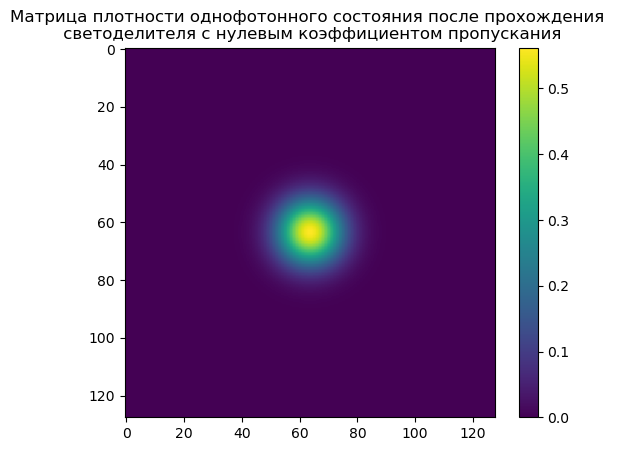

In [8]:
plt.title("Матрица плотности однофотонного состояния после прохождения \n светоделителя с нулевым коэффициентом пропускания")
plt.imshow(one_photon_dm_after_bs(0))
plt.colorbar()

#### Используя формулу (6), можно также показать, как будет меняться среднее число фотонов в модах на выходе светоделителя при разных коэффициентах пропускания (t):

In [9]:
omega = 0.015
t1 = np.arange(180)
reflection = np.sin(omega*t1/2)
transition = np.cos(omega*t1/2)

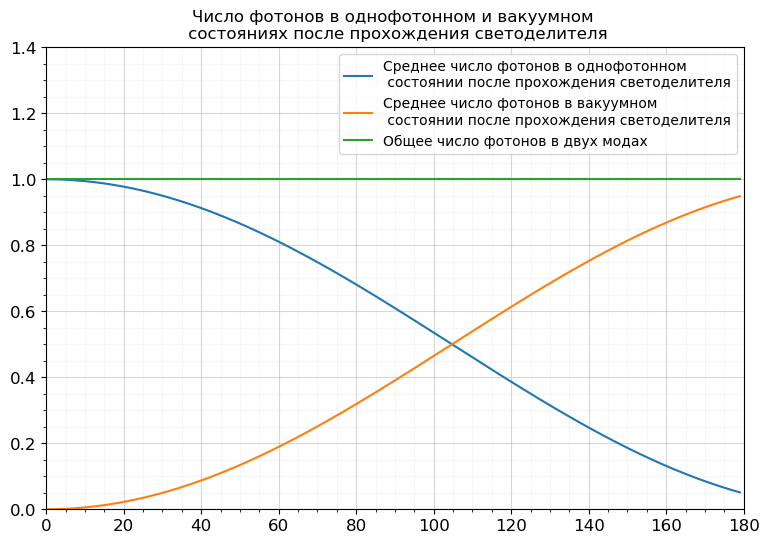

In [10]:
plt.figure(figsize = (9,6))
plt.title("Число фотонов в однофотонном и вакуумном \n состояниях после прохождения светоделителя")
plt.plot(transition**2, label = 'Среднее число фотонов в однофотонном \n состоянии после прохождения светоделителя')
plt.plot(reflection**2, label = 'Среднее число фотонов в вакуумном \n состоянии после прохождения светоделителя')
plt.plot(transition**2 + reflection**2, label = 'Общее число фотонов в двух модах')
plt.ylim(0,1.4)
plt.xlim(0,180)
plt.grid(which = 'major',alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.minorticks_on()
plt.legend()

### Для сравнения вычислим эволюцию числа фотонов в модах с помощью матричной экспоненты и наложим на график выше

In [11]:
def annihilate_photon(n):
    A = np.zeros((n, n))
    for i in range(len(A)-1):
        A[i][i+1] = np.sqrt(i+1)
    return A

In [12]:
def create_photon(n):
    A = np.zeros((n, n))
    for i in range(1, len(A)):
        A[i][i-1] = np.sqrt(i)
    return A

In [13]:
def tensor_product(a, b):
    if len(a.shape) == 2:
        return np.einsum("ijk, klm -> iljm", a.reshape(a.shape[0], a.shape[1], 1), b.reshape(1, b.shape[0], b.shape[1])).reshape(a.shape[0]*b.shape[0], a.shape[1]*b.shape[1])
    else:
        return np.einsum("ik, km -> im", a.reshape(a.shape[0], 1), b.reshape(1, b.shape[0])).reshape(a.shape[0]*b.shape[0])

In [14]:
def create_fock_state(photon_numbers, n):
    a = np.zeros(n)
    a[photon_numbers] = 1 
    return a

In [15]:
def solve_with_matrexp(hamiltonian, time, psi0):
    return scipy.linalg.expm(-1j * hamiltonian * time) @ psi0

In [16]:
def decompose_tp(tensor_product):
    n = int(np.sqrt(len(tensor_product)))
    matrix = tensor_product.reshape(n, n)
    U, S, V = np.linalg.svd(matrix, full_matrices = True)
    return [S[0], S[1]]

In [17]:
theta_ = 0.015
t = 70
n = 12

In [18]:
ham_bs = - (theta_ * 1j / 2) * (tensor_product(create_photon(n), annihilate_photon(n)) - tensor_product(annihilate_photon(n), create_photon(n)))

In [19]:
delta_time = 5
photons_in_signal = []
photons_in_loss = []
for t_ in tqdm(range(0, 36)):
    result = decompose_tp(solve_with_matrexp(ham_bs, t_ * delta_time, tensor_product(create_fock_state(1, n), create_fock_state(0, n))))
    photons_in_signal.append(result[0]**2)
    photons_in_loss.append(result[1]**2)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 51.88it/s]


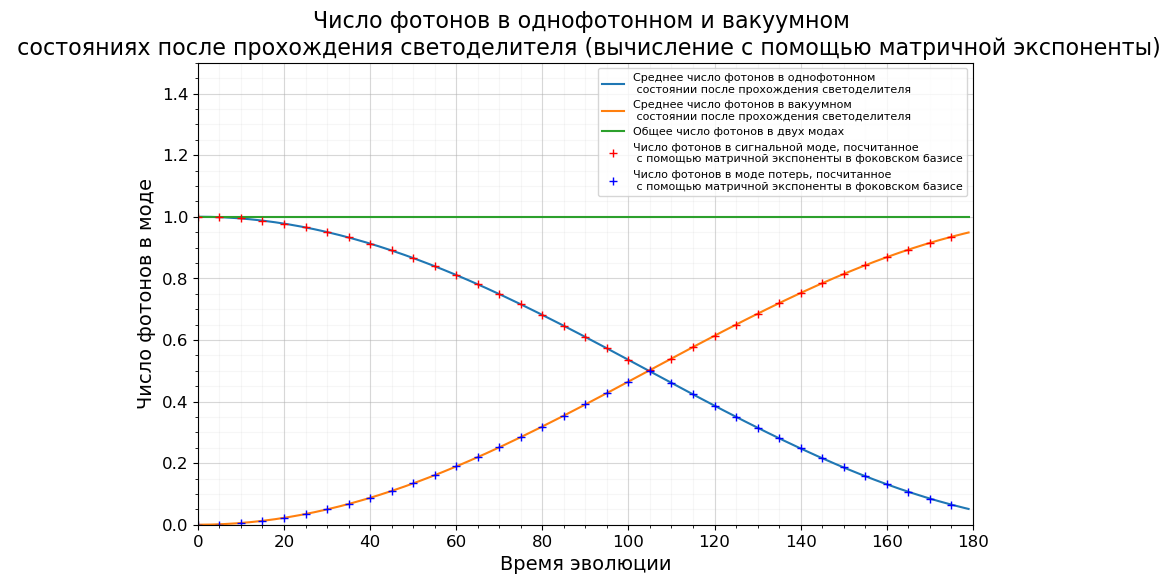

In [20]:
delta_time = 5
plt.figure(figsize = (10,6))
plt.title("Число фотонов в однофотонном и вакуумном \n состояниях после прохождения светоделителя (вычисление с помощью матричной экспоненты)", fontsize = 16)
plt.plot(transition**2, label = 'Среднее число фотонов в однофотонном \n состоянии после прохождения светоделителя')
plt.plot(reflection**2, label = 'Среднее число фотонов в вакуумном \n состоянии после прохождения светоделителя')
plt.plot(transition**2 + reflection**2, label = 'Общее число фотонов в двух модах')
plt.xlabel('Время эволюции', fontsize = 14)
plt.ylabel('Число фотонов в моде', fontsize = 14)
plt.ylim(0,1.5)
plt.xlim(0,180)
plt.grid(which = 'major',alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.minorticks_on()

plt.plot(range(0, 36*delta_time, delta_time), photons_in_signal, 'r+', label = 'Число фотонов в сигнальной моде, посчитанное \n с помощью матричной экспоненты в фоковском базисе')
plt.plot(range(0, 36*delta_time, delta_time), photons_in_loss, 'b+', label = 'Число фотонов в моде потерь, посчитанное \n с помощью матричной экспоненты в фоковском базисе')
#plt.plot(range(0, 36*delta_time, delta_time), list(map(operator.add, photons_in_signal, photons_in_loss)), 'g+')
photons_in_signal[-1], photons_in_loss[-1]

plt.legend(fontsize= 8)

### Сделаем аналогичное вычисление с помощью тензорных сетей

In [21]:
with open('Correct_evolution_short.pkl', 'rb') as f:
    shorten_list_for_matrices = pickle.load(f)

In [22]:
from operator import add
photon_num1 = []
photon_num2 = []
photon_num_common = []
for i in tqdm(range(0, len(shorten_list_for_matrices))):
    reddm1 = mp.find_reduced_density_matrix(shorten_list_for_matrices[i], 0, n1)
    reddm2 = mp.find_reduced_density_matrix(shorten_list_for_matrices[i], 1, n2) 
    reddm1 = reddm1 / np.trace(reddm1)
    reddm2 = reddm2 / np.trace(reddm2)
    photon_num1.append(np.round(mp.calculate_ph_num(reddm1, n1, - x_bond1, step1, bound = "periodic"), 3))
    photon_num2.append(np.round(mp.calculate_ph_num(reddm2, n1, - x_bond1, step1, bound = "periodic"), 3))

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [00:21<00:00, 19.02it/s]


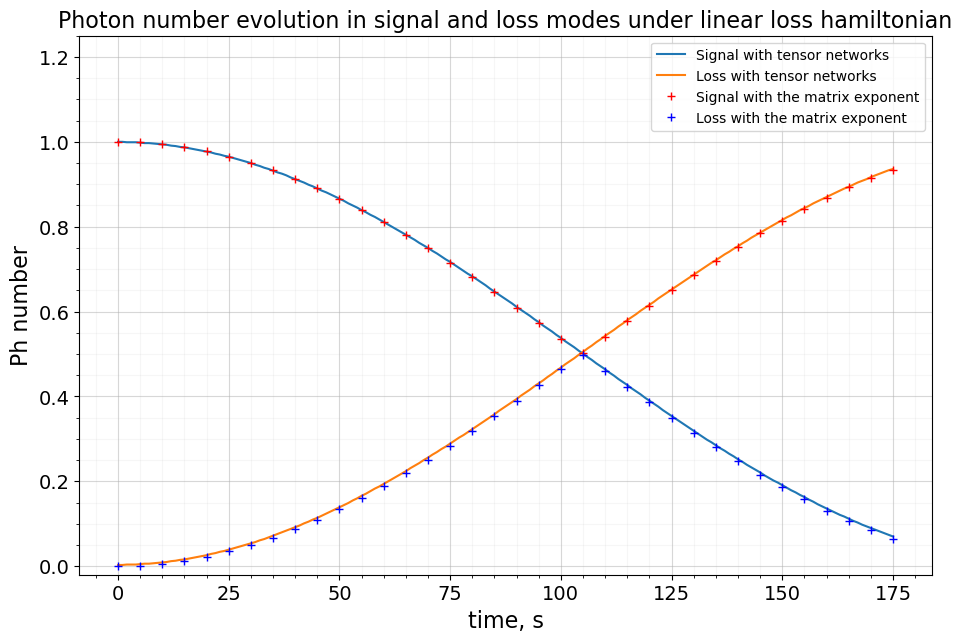

In [23]:
N = 176
plt.figure(figsize = (11,7))
plt.title('Photon number evolution in signal and loss modes under linear loss hamiltonian', fontsize = 16)
plt.plot(np.arange(N) * delta_t * 100, photon_num1[:N], label = "Signal with tensor networks")
plt.plot(np.arange(N) * delta_t * 100, photon_num2[:N], label = "Loss with tensor networks")
#plt.plot(np.arange(N) * delta_t * 500, list(map(add, photon_num1, photon_num2))[:N], label = "Sum")
plt.plot(np.linspace(0, 175, len(photons_in_signal)), photons_in_signal, 'r+', label = "Signal with the matrix exponent")
plt.plot(np.linspace(0, 175, len(photons_in_signal)), photons_in_loss, 'b+', label = "Loss with the matrix exponent")
plt.xlabel("time, s", fontsize = 16)
plt.ylabel("Ph number", fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.grid(which = 'major', alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.1)
plt.ylim((-0.02, 1.25))
plt.minorticks_on()
#plt.savefig("Photon number evolution in signal and loss modes under linear loss hamiltonian")

#### Все три подхода - аналитическая зависимость, решение с помощью матричной экспоненты и решение с помощью тензорных сетей дают полностью эквивалентный результат

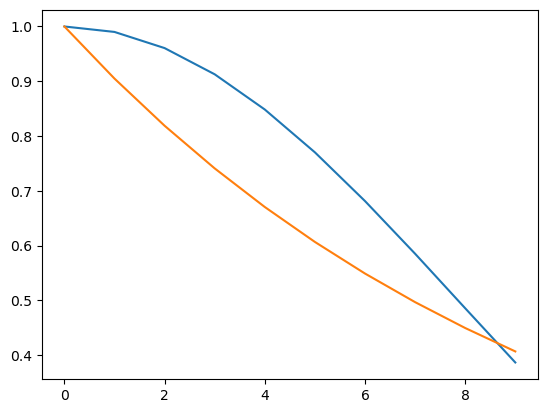

In [5]:
x = np.arange(10)*0.1
(np.cos(x))**2, np.exp(-x)
plt.plot((np.cos(x))**2)
plt.plot(np.exp(-x))

In [87]:
def update_angle(angle):
    return np.arccos(np.cos(angle)**2)

In [88]:
angles = [np.pi/50000]
for i in range(100):
    angles.append(update_angle(angles[i]))

In [104]:
ll = []
for i in tqdm(range(100000000)):
    ll.append((np.cos(np.pi/50000)**2)**i)

100%|████████████████████████████████████████████████████████████████| 100000000/100000000 [03:25<00:00, 486881.34it/s]


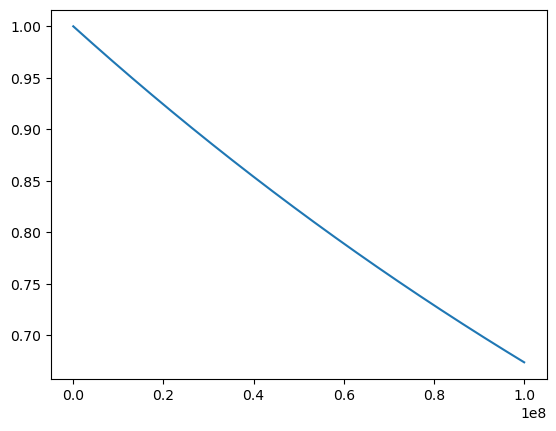

In [105]:
plt.plot(ll)

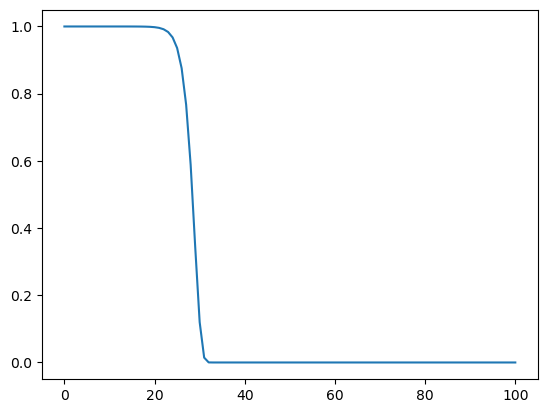

In [97]:
plt.plot(np.cos(angles))
#plt.plot(np.linspace(0, 2*np.pi/5, len(angles2)), np.cos(angles2)**2)
#plt.plot(np.linspace(0, 2*np.pi, len(angles3)), angles3)

In [98]:
np.cos(angles)

array([9.99999998e-01, 9.99999996e-01, 9.99999992e-01, 9.99999984e-01,
       9.99999968e-01, 9.99999937e-01, 9.99999874e-01, 9.99999747e-01,
       9.99999495e-01, 9.99998989e-01, 9.99997979e-01, 9.99995957e-01,
       9.99991915e-01, 9.99983830e-01, 9.99967660e-01, 9.99935321e-01,
       9.99870645e-01, 9.99741308e-01, 9.99482682e-01, 9.98965632e-01,
       9.97932334e-01, 9.95868944e-01, 9.91754954e-01, 9.83577889e-01,
       9.67425463e-01, 9.35912027e-01, 8.75931322e-01, 7.67255681e-01,
       5.88681280e-01, 3.46545650e-01, 1.20093887e-01, 1.44225418e-02,
       2.08009711e-04, 4.32680399e-08, 1.83758918e-15, 6.12323400e-17,
       6.12323400e-17, 6.12323400e-17, 6.12323400e-17, 6.12323400e-17,
       6.12323400e-17, 6.12323400e-17, 6.12323400e-17, 6.12323400e-17,
       6.12323400e-17, 6.12323400e-17, 6.12323400e-17, 6.12323400e-17,
       6.12323400e-17, 6.12323400e-17, 6.12323400e-17, 6.12323400e-17,
       6.12323400e-17, 6.12323400e-17, 6.12323400e-17, 6.12323400e-17,
      